In [1]:
import xarray as xr
import scipy 
import xgcm

import numpy as np

In [2]:
from distributed import Client

client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44935 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44935/status,
Dashboard: /proxy/44935/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35817,Workers: 2
Dashboard: /proxy/44935/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:43127,Total threads: 1
Dashboard: /proxy/43215/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:32769,


In [3]:
areacello_esm = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Ofx/areacello/gn/latest/areacello_Ofx_ACCESS-ESM1-5_historical_r10i1p1f1_gn.nc')

In [4]:
areacella_esm = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-ESM1-5_historical_r10i1p1f1_gn.nc')

In [5]:
### interpolating to JRA grid

In [6]:
friver_jra = xr.open_dataset('/g/data/k10/qo9901/ESMforcing_input/ESM1p5_SSP585.friver.2015_2016.nc')
friver_jra

<xarray.Dataset> Size: 2GB
Dimensions:   (lat: 720, bnds: 2, lon: 1440, time: 365)
Coordinates:
  * lat       (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon       (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time      (time) datetime64[ns] 3kB 2015-01-01 2015-01-02 ... 2015-12-31
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 12kB ...
    lon_bnds  (lon, bnds) float64 23kB ...
    friver    (time, lat, lon) float32 2GB ...
Attributes: (12/36)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    cell_measures:       area: areacello
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-08T12:25:50Z
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.4.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/9f833131-0812-45d0-9420-c1d46fffcec0
    variable_id:         friver
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0

In [7]:
## using scenario data

In [8]:
cd /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Omon/friver/gn/latest

/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r1i1p1f1/Omon/friver/gn/v20210318


In [9]:
friver_monthly_esm = xr.open_dataset('friver_Omon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc')

In [10]:
friver_monthly_esm_av = friver_monthly_esm.isel(time = np.arange(0,60))
friver_monthly_esm_av_rename = friver_monthly_esm_av.rename({'j':'lat', 'i':'lon'})
friver_monthly_esm_av_rename_nw = friver_monthly_esm_av_rename.assign_coords({'lat':friver_monthly_esm_av.latitude.isel(i= 0).values,\
                                                                           'lon':friver_monthly_esm_av.longitude.isel(j= 0).values})
'''
areacello_esm_grid_1 = areacello_esm.rename({'j':'lat'})\
    .assign_coords({'lat':friver_monthly_esm_av.latitude.isel(i= 0).values
                   }) 
'''
areacello_esm_grid = areacello_esm.rename({'j':'lat','i':'lon'})\
    .assign_coords({'lat':friver_monthly_esm_av.latitude.isel(i= 0).values,
                   'lon':friver_monthly_esm_av.longitude.isel(j= 0).values}) ### revert back to i and lat for grid 1 and both for grid 2
'''
grid_o_1 = xgcm.Grid(areacello_esm_grid_1, coords={
                        'X': {'center': 'i'},
                        'Y': {'center': 'lat'}}, periodic = False)
'''
                                                                              
grid_o_2 = xgcm.Grid(areacello_esm_grid.sortby('lon'), coords={
                        'X': {'center': 'lon'},
                        'Y': {'center': 'lat'}}, periodic = False)

# interpolate to the jra lat and lon grid. == have to interpolate X and Y seperately 
# note X is defined as non-periodic even though it is
friver_y_interp = grid_o_2.transform(friver_monthly_esm_av_rename_nw.friver,'Y', friver_jra.lat, target_data = None)
friver_xy_interp = grid_o_2.transform(friver_y_interp.sortby('lon'),'X', friver_jra.lon, target_data = None)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


In [11]:
grid_o_2

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   lon
Y Axis (not periodic, boundary=None):
  * center   lat

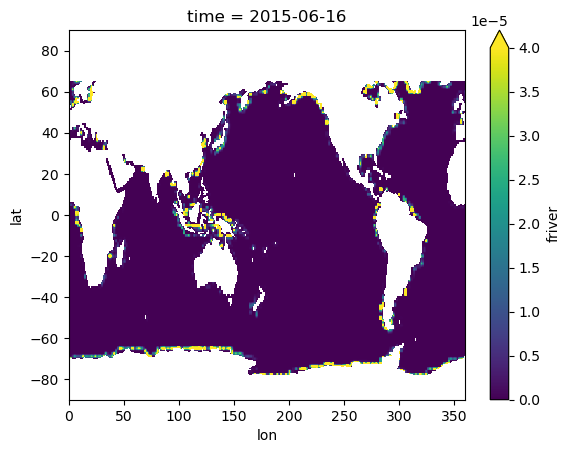

In [56]:
friver_y_interp.isel(time = 5).sortby('lon').T.plot(vmax = 4e-5)

In [13]:
for yr in range(2015,2017):    
    date_mon = friver_monthly_esm.time
    time_bnds = friver_monthly_esm.time_bnds

    months_offset = (yr - 2015 )*12
    
    time_bnds_add = xr.concat([time_bnds.isel( time = tt + months_offset) for tt in range(12)], dim = 'time')#.plot()
    ## add additional variables for OM to read
    runoff_jra_interp = xr.merge([friver_xy_interp.isel(time = range(months_offset, months_offset + 12))\
                                  .assign_coords({'time': date_mon.isel(time = range(months_offset, months_offset + 12)), \
                                              }), \
              friver_jra.lat_bnds, friver_jra.lon_bnds,time_bnds_add])

    ## fill empty cells with 0
    runoff_jra_interp['friver'] = runoff_jra_interp.friver.fillna(0)
    runoff_jra_interp.to_netcdf('/g/data/k10/qo9901/ESMforcing_input/friver_interp_jra_scenario_' + str(yr) + '.nc')
    
    ## update calendar to be compatiable withe model
    ds = nc.Dataset('/g/data/k10/qo9901/ESMforcing_input/friver_interp_jra_scenario_' + str(yr) + '.nc', "r+")
    time_var = ds.variables['time']
    time_var.calendar = 'gregorian' 
    print(ds)
    # Close the dataset
    ds.close()
    

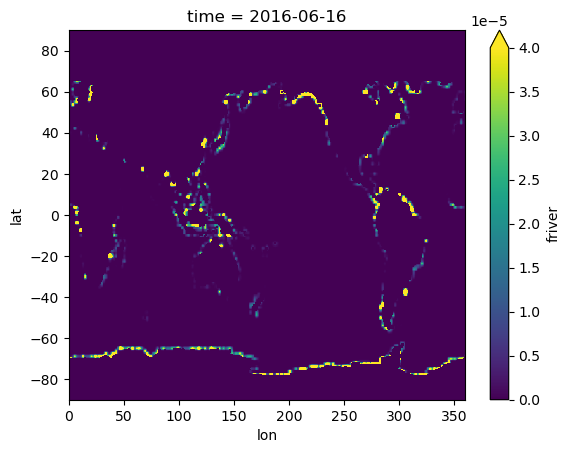

In [14]:
runoff_jra_interp.friver.isel(time = 5).fillna(0).plot(vmax = 4e-5)

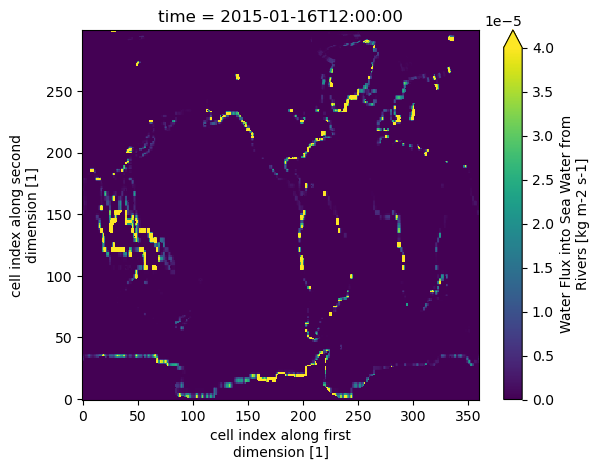

In [71]:
friver_monthly_esm.friver.isel(time = 0).fillna(0).plot(vmax = 4e-5) # original uninterpolated friver

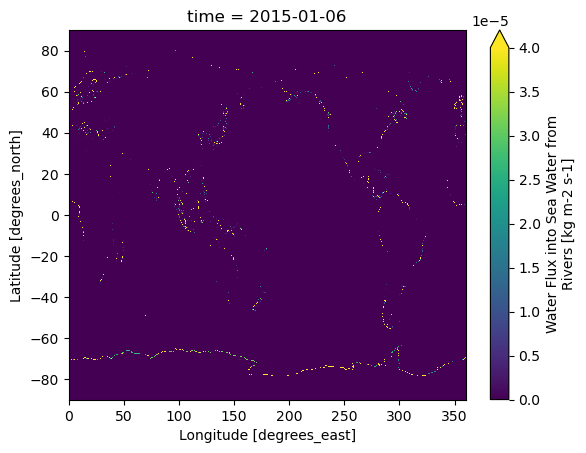

In [15]:
friver_jra.friver.isel(time = 5).plot(vmax = 4e-5) ## looks like less than ESM friver

In [ ]:
# zero for calving data - import friver field and make it zero

In [111]:
for yr in range(2015,2016):
    calv = xr.open_dataset('/g/data/k10/qo9901/ESMforcing_input/friver_interp_jra_scenario_' + str(yr) + '.nc')
    calv['friver']  = calv.friver*0
    calv = calv.rename({'friver':'licalvf'})
    calv.to_netcdf('/g/data/k10/qo9901/ESMforcing_input/ESM1p5_SSP585.licalvf.' + str(yr) + '_blank.nc')
    print(yr)

2015


In [109]:
cd /g/data/k10/qo9901/ESMforcing_input/

/g/data/k10/qo9901/ESMforcing_input


In [110]:
ls

ESM1p5_SSP585.friver.2015_2016.nc
ESM1p5_SSP585_full.friver.2015_2016.nc
ESM1p5_SSP585_full.friver.2015.nc
ESM1p5_SSP585_full.friver.2016_2017.nc
ESM1p5_SSP585_full.friver.2016.nc
ESM1p5_SSP585_full.friver.2017_2018.nc
ESM1p5_SSP585_full.friver.2017.nc
ESM1p5_SSP585_full.friver.2018_2019.nc
ESM1p5_SSP585_full.friver.2018.nc
ESM1p5_SSP585_full.friver.2019_2020.nc
ESM1p5_SSP585_full.friver.2019.nc
ESM1p5_SSP585_full.huss.2015_2016.nc
ESM1p5_SSP585_full.huss.2015.nc
ESM1p5_SSP585_full.huss.2016_2017.nc
ESM1p5_SSP585_full.huss.2016.nc
ESM1p5_SSP585_full.huss.2017_2018.nc
ESM1p5_SSP585_full.huss.2017.nc
ESM1p5_SSP585_full.huss.2018_2019.nc
ESM1p5_SSP585_full.huss.2018.nc
ESM1p5_SSP585_full.huss.2019_2020.nc
ESM1p5_SSP585_full.huss.2019.nc
ESM1p5_SSP585_full.licalvf.2015_2016.nc
ESM1p5_SSP585_full.licalvf.2015.nc
ESM1p5_SSP585_full.licalvf.2016_2017.nc
ESM1p5_SSP585_full.licalvf.2016.nc
ESM1p5_SSP585_full.licalvf.2017_2018.nc
ESM1p5_SSP585_full.licalvf.2017.nc
ESM1p5_SSP585_full.licalvf.2018